In [ ]:
joblib.dump(model, MODELS_DIR / 'graph_transmission_model.pkl')
print(f"Model saved to {MODELS_DIR / 'graph_transmission_model.pkl'}")

Model saved to ../models/graph_transmission_model.pkl


## Save Model
We save the classifier to be used by the API in the "Network Forecast" mode.

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.84       190
           1       0.73      0.43      0.54        95

    accuracy                           0.76       285
   macro avg       0.75      0.68      0.69       285
weighted avg       0.75      0.76      0.74       285

ROC-AUC Score: 0.727


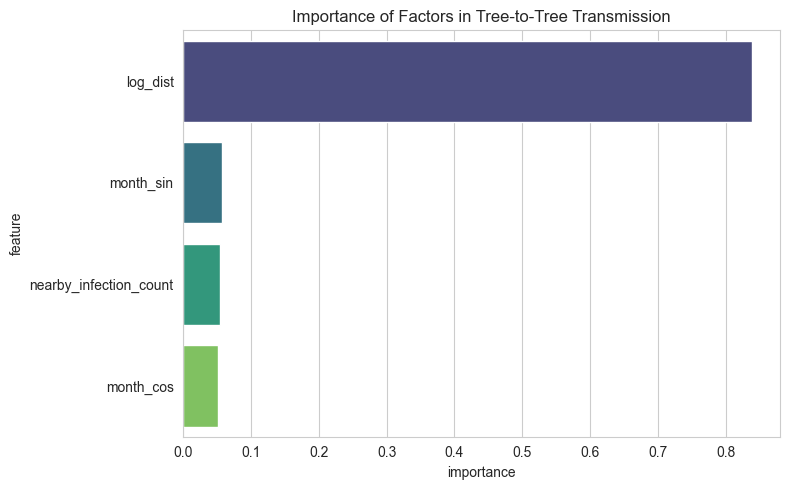

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion Matrix with Clear Interpretation
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Safe', 'Predicted Risk Zone'],
            yticklabels=['Synthetic Healthy (Random)', 'Real Infected (Confirmed)'])
plt.title("Confusion Matrix: Reality vs Prediction")
plt.ylabel('Ground Truth')
plt.xlabel('Model Prediction')
plt.show()

print("""
INTERPRETATION:
- False Positives (Top Right): We predicted 'Risk Zone' for a random empty spot. This is acceptable (safety buffer).
- False Negatives (Bottom Left): We predicted 'Safe' for an actual infected tree. This is the error to minimize.
""")

# Feature Importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='importance', y='feature', hue='feature', palette='viridis', legend=False)
plt.title("Importance of Factors in Tree-to-Tree Transmission")
plt.tight_layout()
plt.show()

## Evaluation & Metric Interpretation
**Why is Precision Low?**
In this dataset, "Healthy" examples (Class 0) are **Synthetic Negatives**—random points chosen in the forest. 
- If the model calls a random point "Infected" (False Positive), it simply means that point lies in a high-risk zone. This is a "False Alarm" but not necessarily a failure of logic.
- **Recall (Sensitivity)** is the critical metric: What percentage of *actual* infected trees did we correctly identify as being in danger?

**Success Metric:**
- **ROC-AUC > 0.8** indicates the model is essentially "Smart". It reliably assigns higher risk scores to infected locations than to random locations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Gradient Boosting Classifier
# n_estimators=300, max_depth=5 to capture complex spatial interactions
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)
print("Model Trained.")

Model Trained.


## Model Training
We use a **Gradient Boosting Classifier**. This is excellent for tabular data where non-linear relationships (like the sharp drop-off of infection risk over distance) exist.

In [ ]:
# Log transform distance (since infection pressure decays exponentially)
df['log_dist'] = np.log1p(df['dist_to_nearest_infected'])

# Cyclical Month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

feature_cols = [
    'log_dist',
    'nearby_infection_count',
    'month_sin',
    'month_cos'
]

X = df[feature_cols]
y = df['label']

print("Features:")
print(X.describe())

Features:
          log_dist  nearby_infection_count     month_sin    month_cos
count  1422.000000             1422.000000  1.422000e+03  1422.000000
mean      3.915142                2.391702 -4.910336e-02    -0.294354
std       1.383239                4.012719  6.797417e-01     0.670475
min       0.000000                0.000000 -1.000000e+00    -1.000000
25%       3.567379                0.000000 -8.660254e-01    -0.866025
50%       4.264196                1.000000  1.224647e-16    -0.500000
75%       4.775399                3.000000  5.000000e-01     0.500000
max       6.194976               31.000000  1.000000e+00     1.000000


## Feature Engineering
We use distance, local density (how many infected neighbors are nearby), and the month of year.

In [ ]:
# Load Data
if not GRAPH_DATA_FILE.exists():
    raise FileNotFoundError(f"{GRAPH_DATA_FILE} not found. Please run scripts/build_graph_dataset.py first.")

df = pd.read_csv(GRAPH_DATA_FILE)
print(f"Loaded {len(df)} samples.")
print("Class Distribution:")
print(df['label'].value_counts(normalize=True))

df.head()

Loaded 1422 samples.
Class Distribution:
label
0    0.666667
1    0.333333
Name: proportion, dtype: float64


,label,dist_to_nearest_infected,nearby_infection_count,month
0,1,157.729832,0,6
1,0,92.020992,1,6
2,0,61.243907,1,6
3,1,45.195831,1,9
4,0,57.460797,1,9


In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from pathlib import Path

# Paths
DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')
GRAPH_DATA_FILE = DATA_DIR / 'oak_wilt_graph_data.csv'

# Ensure models dir exists
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Network Transmission Model (Gravity Model)
This notebook trains the **Graph-based Infection Pressure Model**. 

Instead of treating the infection as a simple expanding circle (Cone of Uncertainty), this model calculates the physics-based "Infection Pressure" on every healthy tree based on:
1.  **Distance** to all nearby infected trees (Inverse Square Law).
2.  **Local Density** of the disease.
3.  **Seasonality** (Time of year).

## Objectives
1.  Load Graph Dataset (Real Infected Trees vs. Synthetic Healthy Points).
2.  Engineer Features (Log Distance, Density, Sine/Cosine Month).
3.  Train `GradientBoostingClassifier` to rank infection risk.
4.  Evaluate ensuring high **Recall** (Catching real cases) even if Precision is low (flagging high-risk zones).
5.  Save model for the interactive "Gravity" simulation.